#### **1) Libraries**

In [1]:
# Don't forget to restart
# !pip install -U tensorflow_probability -q
!pip install ipdb tensorflow==2.5.0 -q
!pip install git+https://github.com/tensorflow/docs -q

     |████████████████████████████████| 786 kB 5.0 MB/s 
     |████████████████████████████████| 368 kB 60.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.19 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.26.0 which is incompatible.
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
from IPython import display

import ipdb
import glob
import imageio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import time
import os
import random
from tqdm import tqdm
from collections import defaultdict

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose


In [3]:
pip list | grep tensorflow

tensorflow                    2.5.0
tensorflow-datasets           4.0.1
tensorflow-docs               0.0.0d22c535c5f3d7d880ff2cd03b8f8786bf5f28965-
tensorflow-estimator          2.5.0
tensorflow-gcs-config         2.5.0
tensorflow-hub                0.12.0
tensorflow-metadata           1.1.0
tensorflow-probability        0.13.0


In [4]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [5]:
# List all physical devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If using Google Colab, save in your Google Drive.

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### **2) Extract Data**

In [7]:
# [KC]: Problem 1
# BATCH_SIZE = 32
BATCH_SIZE = 128

# datasets_names = ['mnist', 'mnist_corrupted', 'fashion_mnist', 'cifar10', 'cifar10_corrupted']
datasets_names = ['mnist', 'mnist_corrupted', 'fashion_mnist', 'cifar10']

In [8]:
def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
    # image = tf.where(image > .5, 1.0, 0.0)
    return image

def _preprocess_label(sample):
    label = tf.cast(sample['label'], tf.int32)
    return label

In [9]:
def get_datasets(datasets_names, batch_size):
    datasets = defaultdict(dict)
    for datasets_name in datasets_names:
        print(f"============================================================================================")
        print(f"\nExtracting {datasets_name.upper()} dataset...\n")
        datasets_raw, datasets_raw_info = tfds.load(name=datasets_name,
                                                    with_info=True,
                                                    as_supervised=False
                                                    )
        print(datasets_raw_info)

        # View some examples from the dataset
        fig, axes = plt.subplots(3, 3, figsize=(8, 8))
        fig.subplots_adjust(hspace=0.2, wspace=0.1)
        for i, (elem, ax) in enumerate(zip(datasets_raw['train'], axes.flat)):
            image = tf.squeeze(elem['image'])
            # print(image)
            label = elem['label']

            ax.imshow(image, cmap='gray')
            ax.text(0.7, -0.12, f'Digit = {label}', ha='right',
                    transform=ax.transAxes, color='black')
            ax.set_xticks([])
            ax.set_yticks([])
            # plt.show()

        # Get
        train_size = 60000 if 'mnist' in datasets_name else 50000
        if 'corrupted' not in datasets_name:
            datasets[datasets_name]['train'] = (datasets_raw['train']
                                                .map(_preprocess)
                                                .batch(batch_size)
                                                .prefetch(tf.data.experimental.AUTOTUNE)
                                                .shuffle(train_size)
                                                )
        datasets[datasets_name]['test'] = (datasets_raw['test']
                                           .map(_preprocess)
                                           .batch(batch_size)
                                           .prefetch(tf.data.experimental.AUTOTUNE)
                                           )
        datasets[datasets_name]['test_label'] = (datasets_raw['test']
                                                 .map(_preprocess_label)
                                                 .batch(batch_size)
                                                 .prefetch(tf.data.experimental.AUTOTUNE)
                                                 )

        if 'corrupted' not in datasets_name:
            #
            print(" - Print one train set image:")
            for train_batch in datasets[datasets_name]['train'].take(1):
                image = train_batch[0].numpy()
            # image = np.squeeze(image, axis=2)
            image = np.squeeze(image)
            plt.figure()
            plt.imshow(image, cmap='gray')
            # plt.title('corresponding image label {}'.format(label))
            plt.colorbar()
            plt.grid(False)
            plt.axis('off')
            plt.show();

        #
        print(" - Print one test set image:")
        for test_batch in datasets[datasets_name]['test'].take(1):
            image = test_batch[0].numpy()
        # image = np.squeeze(image, axis=2)
        image = np.squeeze(image)
        plt.figure()
        plt.imshow(image, cmap='gray')
        # plt.title('corresponding image label {}'.format(label))
        plt.colorbar()
        plt.grid(False)
        plt.axis('off')
        plt.show();

        #
        print(" - Print one test set label:")
        for test_label in datasets[datasets_name]['test_label'].take(1):
            label = test_label[0]
        print(label.numpy())
        print(f"\n")

    return datasets


Extracting MNIST dataset...



local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

 - Print one train set image:


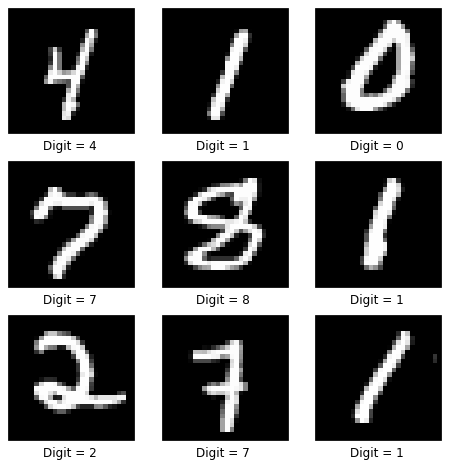

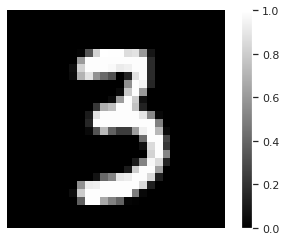

 - Print one test set image:


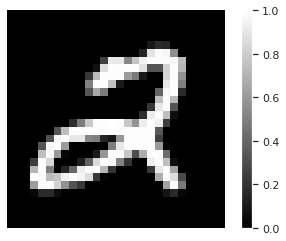

 - Print one test set label:
2



Extracting MNIST_CORRUPTED dataset...



Shuffling and writing examples to /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0.incompleteNH9548/mnist_corrupted-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0.incompleteNH9548/mnist_corrupted-test.tfrecord


Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist_corrupted',
    version=1.0.0,
    description='MNISTCorrupted is a dataset generated by adding 15 corruptions to the test
images in the MNIST dataset. This dataset wraps the static, corrupted MNIST
test images uploaded by the original authors',
    homepage='https://github.com/google-research/mnist-c',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{mu2019mnist,
      title={MNIST-C: A Robustness Benchmark for Computer Vision},
      author={Mu, Norman and Gilmer, Justin},
      journal={arXiv preprint arXiv:1906.02337},
     

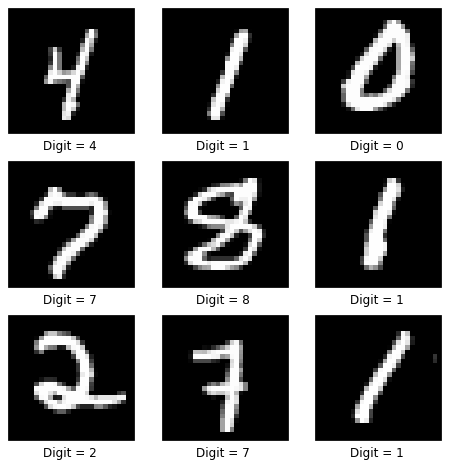

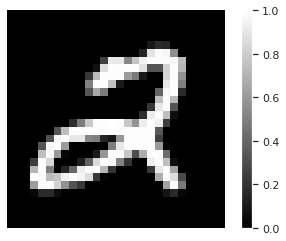

 - Print one test set label:
2



Extracting FASHION_MNIST dataset...



Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteXROA2B/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteXROA2B/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashio

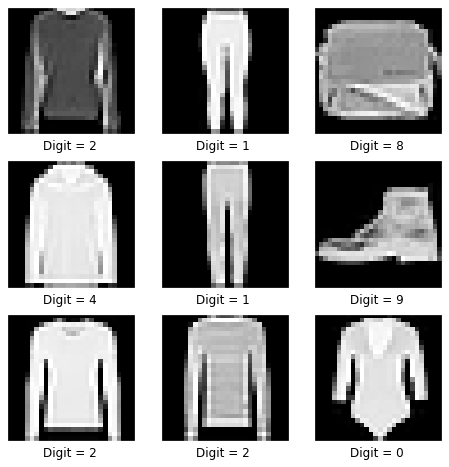

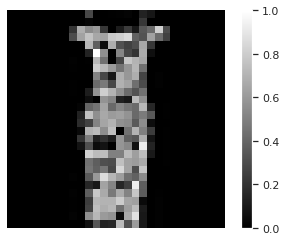

 - Print one test set image:


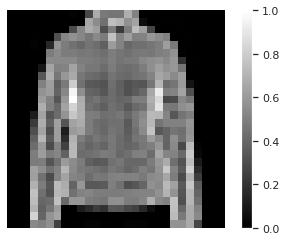

 - Print one test set label:
4



Extracting CIFAR10 dataset...



Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteVG2U63/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteVG2U63/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    

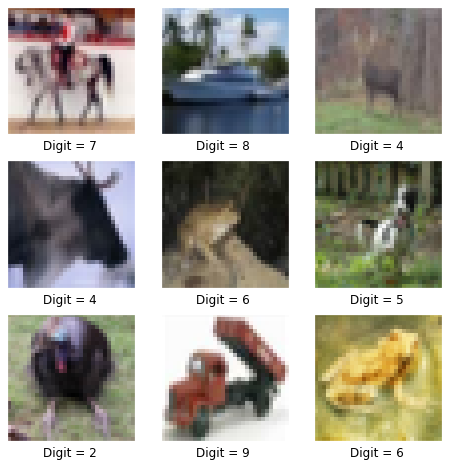

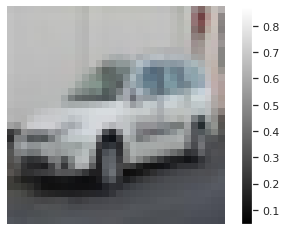

 - Print one test set image:


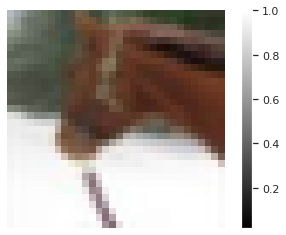

 - Print one test set label:
7


CPU times: user 1min 59s, sys: 13.6 s, total: 2min 13s
Wall time: 2min 1s


In [10]:
%%time
datasets = get_datasets(datasets_names, BATCH_SIZE)

FashionMNIST item mapping:

In [11]:
'''
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
'''

'\n0\tT-shirt/top\n1\tTrouser\n2\tPullover\n3\tDress\n4\tCoat\n5\tSandal\n6\tShirt\n7\tSneaker\n8\tBag\n9\tAnkle boot\n'

CIFAR-10 item mapping:

In [12]:
'''
0	airplane
1	automobile
2	bird
3	cat
4	deer
5	dog
6	frog
7	horse
8	ship
9	truck boot
'''

'\n0\tairplane\n1\tautomobile\n2\tbird\n3\tcat\n4\tdeer\n5\tdog\n6\tfrog\n7\thorse\n8\tship\n9\ttruck boot\n'

#### **3) Model Class**

Credit: https://www.tensorflow.org/api_docs/python/tf/keras/datasets

In [13]:
from tensorflow.keras import layers as tfkl

In [14]:
class Sampler_Z(tfkl.Layer):

    def call(self, inputs):
        mean, logvar = inputs
        # Reparameterize
        eps = tf.random.normal(shape=mean.shape, seed=0)
        z_sample = eps * tf.exp(logvar * .5) + mean
        return z_sample

In [15]:
# Encoder/Decoder layers 1 (MNIST and Fashion MNIST)
class EncoderZ_1(tfkl.Layer):

    def __init__(self, latent_dim, n_filter_base, name="encoder", **kwargs):
        super(EncoderZ_1, self).__init__(name=name, **kwargs)
        # Block-1
        self.conv_layer_1 = tfkl.Conv2D(filters=n_filter_base, kernel_size=3,
                                        strides=1, padding='same', name='conv_1'
                                        )
        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1')
        self.activation_layer_1 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_1')
        # Block-2
        self.conv_layer_2 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=2, padding='same', name='conv_2'
                                        )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2')
        self.activation_layer_2 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_2')
        # Block-3
        self.conv_layer_3 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=2, padding='same', name='conv_3'
                                        )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3')
        self.activation_layer_3 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_3')
        # Block-4
        self.conv_layer_4 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=1, padding='same', name='conv_4'
                                        )
        self.batch_layer_4 = tfkl.BatchNormalization(name='bn_4')
        self.activation_layer_4 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_4')
        # Final Block
        self.flatten_layer = Flatten()
        self.dense_mean = Dense(latent_dim, activation=None, name='z_mean')
        self.dense_raw_stddev = Dense(latent_dim, activation=None,
                                      name='z_raw_stddev'
                                      )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input):
        z = self.conv_layer_1(x_input)
        z = self.batch_layer_1(z)
        z = self.activation_layer_1(z)
        z = self.conv_layer_2(z)
        z = self.batch_layer_2(z)
        z = self.activation_layer_2(z)
        z = self.conv_layer_3(z)
        z = self.batch_layer_3(z)
        z = self.activation_layer_3(z)
        z = self.conv_layer_4(z)
        z = self.batch_layer_4(z)
        z = self.activation_layer_4(z)
        z = self.flatten_layer(z)
        mean = self.dense_mean(z)
        logvar = self.dense_raw_stddev(z)
        z_sample = self.sampler_z((mean, logvar))
        return z_sample, mean, logvar


class DecoderX_1(tfkl.Layer):

    def __init__(self, latent_dim, n_filter_base, name="decoder", **kwargs):
        super(DecoderX_1, self).__init__(name=name, **kwargs)
        # For MNIST / Fashion MNIST images
        self.dense_z_input = tfkl.Dense(units=7*7*n_filter_base*2,
                                        activation=tf.nn.relu
                                        )
        self.reshape_layer = tfkl.Reshape(target_shape=(7, 7, n_filter_base*2))
        self.conv_transpose_layer_1 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=1, 
                                                           padding='same',
                                                           name='conv_transpose_1'
                                                           )
        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1')
        self.activation_layer_1 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_1')
        # Block-2
        self.conv_transpose_layer_2 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           name='conv_transpose_2'
                                                           )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2')
        self.activation_layer_2 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_2')
        # Block-3
        self.conv_transpose_layer_3 = tfkl.Conv2DTranspose(filters=n_filter_base,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           name='conv_transpose_3'
                                                           )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3')
        self.activation_layer_3 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_3')
        # Block-4
        # For MNIST / Fashion MNIST images
        self.conv_transpose_layer_4 = tfkl.Conv2DTranspose(filters=1,
                                                           kernel_size=3,
                                                           strides=1, 
                                                           padding='same',
                                                           name='conv_transpose_4'
                                                           )

    # Functional
    def call(self, z):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.batch_layer_1(x_output)
        x_output = self.activation_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.batch_layer_2(x_output)
        x_output = self.activation_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        x_output = self.batch_layer_3(x_output)
        x_output = self.activation_layer_3(x_output)
        x_output = self.conv_transpose_layer_4(x_output)
        return x_output

In [16]:
class VAEModel(tfk.Model):
    """Convolutional variational autoencoder base model."""

    def __init__(self, latent_dim, n_filter_base, seed):
        super(VAEModel, self).__init__()
        self.encoder = EncoderZ_1(latent_dim, n_filter_base)
        self.decoder = DecoderX_1(latent_dim, n_filter_base)

    @tf.function
    def sample(self, z_sample):
        # z_sample, _, _ = self.encoder(x_sample)
        x_recons_logits = self.decoder(z_sample)
        sample_images = tf.sigmoid(x_recons_logits)  # predictions
        # sample_images = tf.math.sigmoid(x_recons_logits)  # predictions
        return sample_images

    def call(self, x_input):
        z_sample, mean, logvar = self.encoder(x_input)
        x_recons_logits = self.decoder(z_sample)
        return x_recons_logits, z_sample, mean, logvar


In [17]:
class VAE:
    """Variational Autoencoder wrapper."""
    def __init__(self, image_dim, z_dim, n_filter_base=32, 
                 learning_rate=0.0005, beta=1., p_std=1., seed=0
                 ):
        self.optimizer = tfk.optimizers.Adam(learning_rate)
        self.model = VAEModel(z_dim, n_filter_base, seed)
        self.metrics = defaultdict(list)
        self.beta = beta
        self.p_std = p_std
        self.set_random_seeds(seed)

    def train(self, train_dataset, test_dataset, test_label, batch_size=0, 
              n_epoch=10, n_sample=4):
        # Pick a sample of the test set for generating output images
        # num_examples_to_generate = n_sample
        assert batch_size >= n_sample
        for test_batch, test_batch_label in zip(test_dataset.take(1),
                                                test_label.take(1)
                                                ):
            test_sample = test_batch[0:n_sample, :, :, :]
            test_sample_label = test_batch_label[0:n_sample]

        for epoch in range(1, n_epoch + 1):
            start_time = time.time()
            for train_x in tqdm(train_dataset):
                self.train_step(train_x)
            end_time = time.time()

            # loss = tfk.metrics.Mean()
            for test_x in test_dataset:
                # loss(self.compute_loss(test_x))
                loss, neg_ll, kl_div = self.compute_loss(test_x)
            display.clear_output(wait=False)
            print(f"Epoch: {epoch}, Test set Loss: {loss}, " + \
                  f"Test set Recon: {neg_ll}, Test set KL: {kl_div}, " + \
                  f"time elapse for current epoch: {end_time - start_time}"
                  )
            self.metrics['loss'].append(loss.numpy())
            self.metrics['recon_loss'].append(neg_ll.numpy())
            self.metrics['kl_div'].append(kl_div.numpy())
            if n_sample <= 16:
                self.generate_and_save_images(epoch, test_sample)
            self.plot_label_clusters(test_sample, test_sample_label)

    @tf.function
    def train_step(self, x_true):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x_true, True)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    def compute_loss(self, x_true, train=False):
        x_recons_logits, z_sample, mean, logvar = self.model(x_true)
        # Sigmoid Cross Entropy Loss 
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_recons_logits,
                                                            labels=x_true
                                                            )
        # Negative Log-Likelihood
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])  # log-likelihood
        neg_ll = -logpx_z  # negative log-likelihood
        # KL-Divergence
        logpz = self.log_normal_pdf(z_sample, 0., self.p_std)
        logqz_x = self.log_normal_pdf(z_sample, mean, logvar)
        kl_div = logqz_x - logpz
        # ELBO
        neg_ll_mean = tf.math.reduce_mean(neg_ll)
        kl_div_mean = tf.math.reduce_mean(kl_div)
        # elbo = -self.beta*kl_div_mean + neg_ll_mean
        loss = neg_ll_mean + self.beta*kl_div_mean
        if train:
            return loss
        return loss, neg_ll_mean, kl_div_mean
        # return tf.stack([loss, elbo, neg_ll_mean, kl_div_mean])

    def generate_and_save_images(self, epoch, test_sample):
        z_sample, _, _ = self.model.encoder(test_sample)
        decoder_sample_images = self.model.sample(z_sample)  # predictions
        fig = plt.figure(figsize=(4, 4))
        for i in range(decoder_sample_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(decoder_sample_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show();

    def plot_label_clusters(self, test_sample, test_sample_label):
        # display a 2D plot of the digit classes in the latent space
        z_sample, _, _ = self.model.encoder(test_sample)
        colors = ['pink', 'red', 'orange', 'yellow', 'green',
                  'blue', 'purple', 'brown', 'gray', 'black'
                  ]
        plt.figure(figsize=(4, 4))
        plt.scatter(z_sample[:, 0], z_sample[:, 1], c=test_sample_label,
                    cmap=matplotlib.colors.ListedColormap(colors)
                    )
        plt.colorbar()
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.show();

    def set_random_seeds(self, seed):
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)


#### **4) Models Train**

In [18]:
datasets['mnist']['train'], datasets['mnist']['test']

(<ShuffleDataset shapes: (None, 28, 28, 1), types: tf.float32>,
 <PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>)

In [19]:
datasets['cifar10']['train'], datasets['cifar10']['test']

(<ShuffleDataset shapes: (None, 32, 32, 3), types: tf.float32>,
 <PrefetchDataset shapes: (None, 32, 32, 3), types: tf.float32>)

In [20]:
# vae init params
input_dim = 28  # image dim
image_dim = (28, 28, 1)
# image_dim = (224, 224, 3)
z_dim = 2  # latent dim, set the dimensionality of the latent space to a plane for visualization later
n_filter_base = 32  # number of base filters in the CNN (a lot of filters?)
learning_rate = 0.0005  # uses for the internal Adam opt

# vae.train params
n_epoch = 10  # number of epochs
batch_size = BATCH_SIZE
show_display = True
display_sample = False
n_sample = 16  #16  # number of example outputs to sample and generate, also n_display
seed = 0
beta_list = [float(i) for i in range(1, 4)]  # VAE beta
# p_std_list = [float(i) for i in range(1, 5)]  # prior std
# beta_list = [i/10. for i in range(10, 30+2, 2)]  # VAE beta
# p_std_list = [i/10. for i in range(10, 30+2, 2)]  # prior std
beta_list

[1.0, 2.0, 3.0]

In [21]:
beta_vae_list = {}
prior_vae_list = {}

Epoch: 10, Test set Loss: 163.85105895996094, Test set Recon: 150.78656005859375, Test set KL: 4.354832172393799, time elapse for current epoch: 5.302817106246948


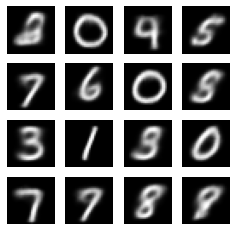

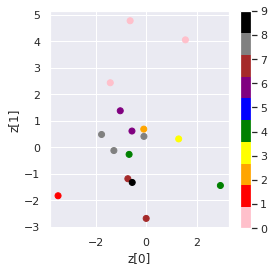

CPU times: user 4min 14s, sys: 33.4 s, total: 4min 47s
Wall time: 4min 56s


In [22]:
%%time
for beta in beta_list:
    beta_vae_list[beta] = VAE(image_dim, z_dim, beta=beta, seed=seed)
    beta_vae_list[beta].train(datasets['mnist']['train'],
                              datasets['mnist']['test'],
                              datasets['mnist']['test_label'],
                              batch_size,
                              n_epoch,
                              n_sample,
                              )

In [23]:
# %%time
# for p_std in p_std_list:
#     prior_vae_list[p_std] = VAE(image_dim, z_dim, p_std=p_std)
#     prior_vae_list[p_std].train(datasets['mnist']['train'],
#                                 datasets['mnist']['test'],
#                                 datasets['mnist']['test_label'],
#                                 batch_size,
#                                 n_epoch,
#                                 n_sample,
#                                 )

In [24]:
beta_vae_list.keys()  # , prior_vae_list.keys()

dict_keys([1.0, 2.0, 3.0])

#### **5) Models Display**

Use vanilla VAE model with prior std = 1 as example

In [25]:
vae = beta_vae_list[1]

In [26]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

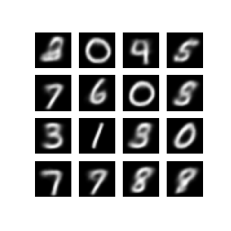

In [27]:
plt.imshow(display_image(n_epoch))
plt.axis('off')  # Display images

In [28]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


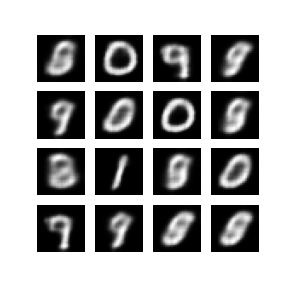

In [29]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [30]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

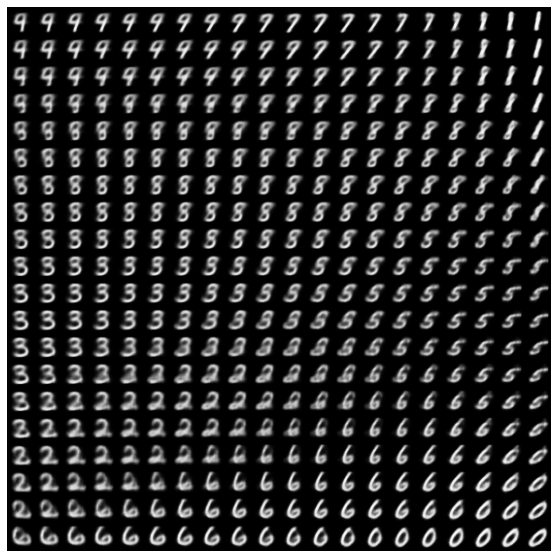

In [31]:
plot_latent_images(vae.model, 20)

Summarize history for loss

In [32]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [33]:
beta_vae_list.keys(), prior_vae_list.keys()

(dict_keys([1.0, 2.0, 3.0]), dict_keys([]))

In [34]:
max_beta = max(beta_vae_list.keys())
max_beta

3.0

In [35]:
x = range(1, n_epoch+1)

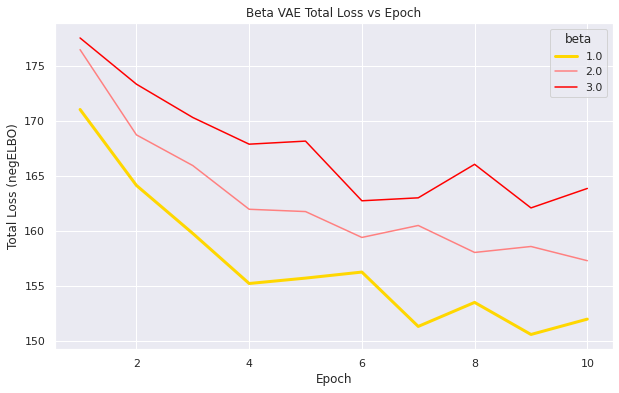

In [45]:
for beta, vae in beta_vae_list.items():
    y = vae.metrics['loss']
    if beta == 1:
        plt.plot(x, y, label=beta, color=lighten_color('gold', 1), lw=3)
    else:
        plt.plot(x, y, label=beta, color=lighten_color('red', (beta-1)/(max_beta-1)))
plt.title('Beta VAE Total Loss vs Epoch')
plt.ylabel('Total Loss (negELBO)')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.legend(title='beta')
plt.rcParams["figure.figsize"] = (10, 6)
plt.show();

In [46]:
# for beta, vae in beta_vae_list.items():
#     y = vae.metrics['beta_elbo']
    # if beta == 1:
    #     plt.plot(x, y, label=beta, color=lighten_color('gold', 1), lw=2)
    # else:
    #     plt.plot(x, y, label=beta, color=lighten_color('purple', (beta-1)/(max_beta-1)))
# plt.title('Beta VAE ELBO vs Epoch')
# plt.ylabel('ELBO')
# plt.xlabel('Epoch')
# # plt.ylim(ymin=0)
# plt.legend(title='beta')
# plt.rcParams["figure.figsize"] = (10, 6)
# plt.show();

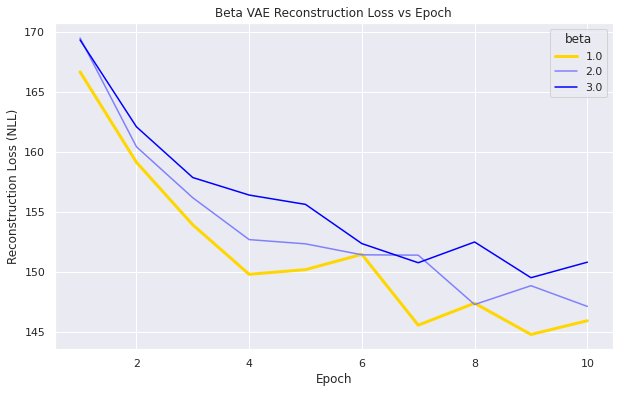

In [47]:
for beta, vae in beta_vae_list.items():
    y = vae.metrics['recon_loss']
    if beta == 1:
        plt.plot(x, y, label=beta, color=lighten_color('gold', 1), lw=3)
    else:
        plt.plot(x, y, label=beta, color=lighten_color('blue', (beta-1)/(max_beta-1)))
plt.title('Beta VAE Reconstruction Loss vs Epoch')
plt.ylabel('Reconstruction Loss (NLL)')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.legend(title='beta')
plt.rcParams["figure.figsize"] = (10, 6)
plt.show();

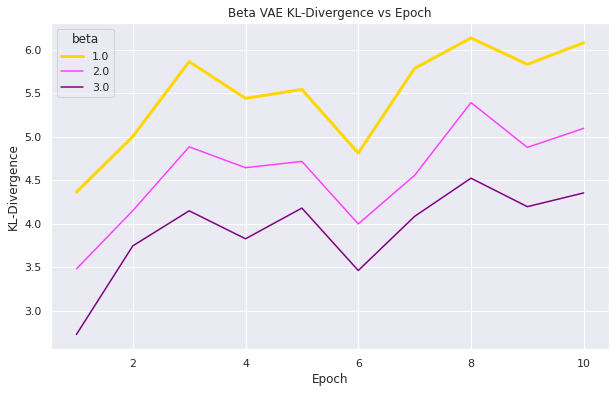

In [48]:
for beta, vae in beta_vae_list.items():
    y = vae.metrics['kl_div']
    if beta == 1:
        plt.plot(x, y, label=beta, color=lighten_color('gold', 1), lw=3)
    else:
        plt.plot(x, y, label=beta, color=lighten_color('purple', (beta-1)/(max_beta-1)))
plt.title('Beta VAE KL-Divergence vs Epoch')
plt.ylabel('KL-Divergence')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.legend(title='beta')
plt.rcParams["figure.figsize"] = (10, 6)
plt.show();

In [49]:
# prior_vae_list.items()

In [50]:
# for p_std, vae in prior_vae_list.items():
#     y = vae.metrics['loss']
#     if p_std == 1:
#         plt.plot(x, y, label=p_std, color=lighten_color('gold', 1), lw=3)
#     # elif p_std <= 2:
#     #     # continue
#     #     plt.plot(x, y, label=p_std, color=lighten_color('indigo', (p_std-1)/2))
#     else:
#         # continue
#         plt.plot(x, y, label=p_std, color=lighten_color('indigo', (p_std)/3))
# plt.title('VAE Metric vs Epoch')
# plt.ylabel('Metric (-ELBO)')
# plt.xlabel('Epoch')
# # plt.ylim(ymin=0)
# plt.legend(title='prior std')
# plt.rcParams["figure.figsize"] = (16, 10)
# plt.show();

In [51]:
# for p_std, vae in prior_vae_list.items():
#     y = vae.metrics['elbo']
#     plt.plot(x, y, label = int(p_std), color=lighten_color('indigo', p_std/5))
# plt.title('VAE Loss vs Epoch')
# plt.ylabel('Loss (-ELBO)')
# plt.xlabel('Epoch')
# # plt.ylim(ymin=0)
# plt.legend(title='prior std')
# plt.rcParams["figure.figsize"] = (16, 10)
# plt.show();

In [52]:
# plt.plot(range(1, n_epoch+1), vae.metrics['loss'])
# plt.title('Model Loss (-ELBO)')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# # plt.ylim(ymin=0)
# plt.show();